# **Homework 12 - Reinforcement Learning**

If you have any problem, e-mail us at ntu-ml-2021spring-ta@googlegroups.com



## Preliminary work

First, we need to install all necessary packages.
One of them, gym, builded by OpenAI, is a toolkit for developing Reinforcement Learning algorithm. Other packages are for visualization in colab.

In [ ]:
'''
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/Colab Notebooks/') 
os.listdir() 
'''

"\nfrom google.colab import drive\ndrive.mount('/content/drive')\n\nimport os\nos.chdir('/content/drive/My Drive/Colab Notebooks/') \nos.listdir() \n"

In [ ]:
!apt update
!apt install python-opengl xvfb -y
!pip install gym[box2d]==0.18.3 pyvirtualdisplay tqdm numpy==1.19.5 torch==1.8.1

Reading package lists... Done
E: Could not open lock file /var/lib/apt/lists/lock - open (13: Permission denied)
E: Unable to lock directory /var/lib/apt/lists/
W: Problem unlinking the file /var/cache/apt/pkgcache.bin - RemoveCaches (13: Permission denied)
W: Problem unlinking the file /var/cache/apt/srcpkgcache.bin - RemoveCaches (13: Permission denied)
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes



Next, set up virtual display，and import all necessaary packages.

In [ ]:
%%capture
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

%matplotlib inline
import matplotlib.pyplot as plt

from IPython import display

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm.notebook import tqdm

# Warning ! Do not revise random seed !!!
# Your submission on JudgeBoi will not reproduce your result !!!
Make your HW result to be reproducible.


In [ ]:
seed = 543 # Do not change this
def fix(env, seed):
  env.seed(seed)
  env.action_space.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)
  random.seed(seed)
  torch.set_deterministic(True)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

Last, call gym and build an [Lunar Lander](https://gym.openai.com/envs/LunarLander-v2/) environment.

In [ ]:
%%capture
import gym
import random
env = gym.make('LunarLander-v2')
fix(env, seed) # fix the environment Do not revise this !!!

## What Lunar Lander？

“LunarLander-v2”is to simulate the situation when the craft lands on the surface of the moon.

This task is to enable the craft to land "safely" at the pad between the two yellow flags.
> Landing pad is always at coordinates (0,0).
> Coordinates are the first two numbers in state vector.

![](https://gym.openai.com/assets/docs/aeloop-138c89d44114492fd02822303e6b4b07213010bb14ca5856d2d49d6b62d88e53.svg)

"LunarLander-v2" actually includes "Agent" and "Environment". 

In this homework, we will utilize the function `step()` to control the action of "Agent". 

Then `step()` will return the observation/state and reward given by the "Environment".

### Observation / State

First, we can take a look at what an Observation / State looks like.

In [ ]:
print(env.observation_space)

Box(-inf, inf, (8,), float32)



`Box(8,)`means that observation is an 8-dim vector
### Action

Actions can be taken by looks like

In [ ]:
print(env.action_space)

Discrete(4)


`Discrete(4)` implies that there are four kinds of actions can be taken by agent.
- 0 implies the agent will not take any actions
- 2 implies the agent will accelerate downward
- 1, 3 implies the agent will accelerate left and right

Next, we will try to make the agent interact with the environment. 
Before taking any actions, we recommend to call `reset()` function to reset the environment. Also, this function will return the initial state of the environment.

In [ ]:
initial_state = env.reset()
print(initial_state)

[ 0.00396109  1.4083536   0.40119505 -0.11407257 -0.00458307 -0.09087662
  0.          0.        ]


Then, we try to get a random action from the agent's action space.

In [ ]:
random_action = env.action_space.sample()
print(random_action)

0


More, we can utilize `step()` to make agent act according to the randomly-selected `random_action`.
The `step()` function will return four values:
- observation / state
- reward
- done (True/ False)
- Other information

In [ ]:
observation, reward, done, info = env.step(random_action)

In [ ]:
print(observation)
print(reward)
print(done)
print(info) # nothing


[ 0.00792227  1.4052099   0.40065318 -0.13973697 -0.00907371 -0.08982072
  0.          0.        ]
-0.8588845024543161
False
{}


### Reward


> Landing pad is always at coordinates (0,0). Coordinates are the first two numbers in state vector. Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. If lander moves away from landing pad it loses reward back. Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main engine is -0.3 points each frame. Solved is 200 points. 

In [ ]:
print(reward)

-0.8588845024543161


### Random Agent
In the end, before we start training, we can see whether a random agent can successfully land the moon or not.

In [ ]:
'''
env.reset()

img = plt.imshow(env.render(mode='rgb_array'))

done = False
while not done:
    action = env.action_space.sample()
    observation, reward, done, _ = env.step(action)

    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)
'''

"\nenv.reset()\n\nimg = plt.imshow(env.render(mode='rgb_array'))\n\ndone = False\nwhile not done:\n    action = env.action_space.sample()\n    observation, reward, done, _ = env.step(action)\n\n    img.set_data(env.render(mode='rgb_array'))\n    display.display(plt.gcf())\n    display.clear_output(wait=True)\n"

## Policy Gradient
Now, we can build a simple policy network. The network will return one of action in the action space.

In [ ]:
class PolicyGradientNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 4)

    def forward(self, state):
        hid = torch.tanh(self.fc1(state))
        hid = torch.tanh(self.fc2(hid))
        return F.softmax(self.fc3(hid), dim=-1) # calculate with row

Then, we need to build a simple agent. The agent will acts according to the output of the policy network above. There are a few things can be done by agent:
- `learn()`：update the policy network from log probabilities and rewards.
- `sample()`：After receiving observation from the environment, utilize policy network to tell which action to take. The return values of this function includes action and log probabilities. 

In [ ]:
from torch.optim.lr_scheduler import StepLR
class PolicyGradientAgent():
    
    def __init__(self, network):
        self.network = network
        self.optimizer = optim.RMSprop(self.network.parameters(), lr=1e-4)
        #self.optimizer = optim.SGD(self.network.parameters(), lr=0.001)

        
    def forward(self, state):
        return self.network(state)
    def learn(self, log_probs, rewards):
        loss = (-log_probs *rewards).sum() # You don't need to revise this to pass simple baseline (but you can)
        # add (-) to minimize loss => maximize reward
        #print("loss: ", loss)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

            
    def sample(self, state):
        action_prob = self.network(torch.FloatTensor(state))
        action_dist = Categorical(action_prob) # create the probability distribution based on the network actor
        action = action_dist.sample() # get a random sample from the probability distribution
        log_prob = action_dist.log_prob(action) # calculate log value of the corresponding action probability 
        return action.item(), log_prob

## DQN
Now, we can build a DQN network. The network will return one of action in the action space.

In [ ]:
class DQN(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size=8, action_size=4, fc1_units=64, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(DQN, self).__init__() # inherit
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values(reward)."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


Then, we need to build a simple agent. The agent will acts according to the output of the policy network above. There are a few things can be done by agent:
- `learn()`：update the policy network from log probabilities and rewards.
- `sample()`：After receiving observation from the environment, utilize policy network to tell which action to take. The return values of this function includes action and log probabilities. 

In [ ]:
from collections import namedtuple

class ReplayMemory:
    """Fixed-size buffer to store experience tuples."""
    def __init__(self, CAPACITY):
        self.capacity = CAPACITY  
        self.memory = []  
        self.index = 0  
        self.transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))
        
    def push(self, state, action, state_next, reward):
        """Push a new experience to memory."""
        if len(self.memory) < self.capacity: # if still has capacity, initialize memory[index] to None
            self.memory.append(None)

        self.memory[self.index] = self.transition(state, action, state_next, reward)

        self.index = (self.index + 1) % self.capacity  # circular index

    def sample(self, batch_size):
        """Randomly sample a batch of experiences from memory."""
        return random.sample(self.memory, batch_size)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [ ]:
class DQNAgent():
    """Interacts with and learns from the environment."""
    def __init__(self, num_states, num_actions):
        """Initialize an Agent object."""
        
        self.num_states = num_states
        self.num_actions = num_actions
        
        # Replay memory
        self.memory_capacity = 10000
        self.memory = ReplayMemory(self.memory_capacity)
        
        # Q-Network
        self.main_q_network = DQN() 
        self.target_q_network = DQN()
        
        # optimizer
        self.optimizer = optim.RMSprop(self.main_q_network.parameters(), lr=1e-4)
    
    def update_q_function(self):
        '''update q function'''
        
        # no enough samples, just return
        if len(self.memory) < BATCH_SIZE:
            return
        # If enough samples are available in memory, get random subset and learn
        self.batch, self.state_batch, self.action_batch, self.reward_batch, self.non_final_next_states = self.make_minibatch()
        
        self.expected_state_action_values = self.get_expected_state_action_values()

        self.update_main_q_network()

    def make_minibatch(self):
        '''Creating a mini-batch'''

        transitions = self.memory.sample(BATCH_SIZE)

        Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))
        batch = Transition(*zip(*transitions))


        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                           if s is not None])

        return batch, state_batch, action_batch, reward_batch, non_final_next_states

    def get_expected_state_action_values(self):
        '''calculate Q（St,at）'''

        self.main_q_network.eval()
        self.target_q_network.eval()

        self.state_action_values = self.main_q_network(
            self.state_batch).gather(1, self.action_batch)

        non_final_mask = torch.BoolTensor(tuple(map(lambda s: s is not None,
                                                    self.batch.next_state)))
        # set all state to 0
        next_state_values = torch.zeros(BATCH_SIZE)

        next_state_values[non_final_mask] = self.target_q_network(
            self.non_final_next_states).max(1)[0].detach()
        # DQN formula
        expected_state_action_values = self.reward_batch + GAMMA * next_state_values
        
        return expected_state_action_values 
        
    def get_action(self, state, episode, test=False):
        """Returns actions for given state as per current policy."""
        if test:
            self.main_q_network.eval()
            with torch.no_grad():
                # t.max(1) will return largest column value of each row.
                # second column on max result is index of where max element was
                # found, so we pick action with the larger expected reward.
                action = self.main_q_network(torch.from_numpy(state).unsqueeze(0)).max(1)[1].view(1, 1)
            return action.item()
        
        global steps_done
        # Epsilon-greedy policy
        # https://www.baeldung.com/cs/epsilon-greedy-q-learning 
        # pick action by
        # 1:max reward if epsilon < np.random.uniform
        # 2:otherwise, pick action randomly

        #epsilon = episode
        #epsilon = 0.5 * (1 / (episode + 1))
        epsilon = EPS_END + (EPS_START - EPS_END) * \
                np.exp(-1. * steps_done / EPS_DECAY)
        #print('epsilon', epsilon)
        
        steps_done += 1
        
        if epsilon <= np.random.uniform(0, 1):
            #print('use max')
            self.main_q_network.eval()
            with torch.no_grad():
                # t.max(1) will return largest column value of each row.
                # second column on max result is index of where max element was
                # found, so we pick action with the larger expected reward.
                action = self.main_q_network(state).max(1)[1].view(1, 1)
        else:
            #print('random')
            action = torch.LongTensor(
                [[random.randrange(self.num_actions)]])  
            
        return action

    def update_main_q_network(self):
        
        '''update main q net'''

        # set train mode
        self.main_q_network.train()
        # Hurberloss function
        # expected_state_action_values (minbatch,)->(minbatchx1)

        #https://pytorch.org/docs/stable/generated/torch.nn.SmoothL1Loss.html#torch.nn.SmoothL1Loss 
        # temporal difference error
        loss = F.smooth_l1_loss(self.state_action_values,
                                self.expected_state_action_values.unsqueeze(1))

        # update
        self.optimizer.zero_grad()  # reset gradient
        loss.backward()  # backpropagation
        for param in self.main_q_network.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()  # update network


    def memorize(self, state, action, state_next, reward):
        '''save state, action, state_next, reward into replay memory'''
        self.memory.push(state, action, state_next, reward)

    def update_target_q_function(self):
        
        '''synchronize Target Q-Network as Main Q-Network'''
        self.target_q_network.load_state_dict(self.main_q_network.state_dict())  


Lastly, build a network and agent to start training.

In [ ]:
actor_network = PolicyGradientNetwork()
actor_agent = PolicyGradientAgent(actor_network)

network = DQN()
agent = DQNAgent(env.observation_space.shape[0], env.action_space.n)

## Trainin Agent

Now let's start to train our agent.
Through taking all the interactions between agent and environment as training data, the policy network can learn from all these attempts,

In [ ]:
EPISODE_PER_BATCH = 5  # update agent every "EPISODE_PER_BATCH" episodes
NUM_BATCH = 600        # total update number
BATCH_SIZE = 32
GAMMA = 0.99           # weight decay
EPS_START = 0.9        # for epsilon 
EPS_END = 0.05         # for epsilon 
EPS_DECAY = 200        # for epsilon 

best_score = 0
best_batch = 0


# ensure network is in training mode before training start
agent.main_q_network.train()
agent.target_q_network.train()
actor_agent.network.train()  
steps_done = 0

avg_total_rewards, avg_final_rewards = [], []

prg_bar = tqdm(range(NUM_BATCH))
for batch in prg_bar:
    print(f"Current batch : ", batch)  
    rewards = []
    log_probs = []
    total_rewards, final_rewards = [], []
    actor_td_error = []
    
    # collect training data
    for episode in range(EPISODE_PER_BATCH):
        
        observation = env.reset() 
        state = observation  # use observation as state s
        state = torch.from_numpy(state).type(
                torch.FloatTensor)  # 
        state = torch.unsqueeze(state, 0)  # size from 4 to 1x4
        total_reward, total_step = 0, 0

        while True:

            action = agent.get_action(state, batch)  
            # get action a_t
            # perform action a_t, then calculate s_{t+1} and get done flag 
            # get info base on action result
        
            observation_next, reward, done, _ = env.step(action.item())  # no info flag，so set it as _

            total_reward += reward
            total_step += 1
            rewards.append(reward) 

            if done:
                state_next = None  # no next state so store it as None

            else:
                state_next = observation_next  
                state_next = torch.from_numpy(state_next).type(
                        torch.FloatTensor)  
                state_next = torch.unsqueeze(state_next, 0)  
                
            # store this action result into memory 
            agent.memorize(state, action, state_next, torch.FloatTensor([reward]))
            
            # update q function with experience replay
            agent.update_q_function()
            
            # collect data for actor network
            actor_action, log_prob = actor_agent.sample(observation) # at, log(at|st)
            log_probs.append(log_prob) # [log(a1|s1), log(a2|s2), ...., log(at|st)]
            
            agent.main_q_network.eval()
            agent.target_q_network.eval()
            state_value = agent.main_q_network(state).detach().numpy()[0][actor_action]
            if state_next != None:
                next_state_value = agent.target_q_network(state_next).detach().numpy()[0][actor_action]
            else:
                next_state_value = 0
            
            td_error = reward + GAMMA*next_state_value - state_value
            actor_td_error.append(td_error)
            #train actor at every step as Q-network
            actor_agent.learn(log_prob, td_error)

            agent.main_q_network.train()
            agent.target_q_network.train()


            # update observation state
            state = state_next
            observation = observation_next
            
            # 
            if done:
                final_rewards.append(reward)
                total_rewards.append(total_reward)
                break
                

    #print(f"rewards looks like ", np.shape(rewards))      
    avg_total_reward = sum(total_rewards) / len(total_rewards)
    avg_final_reward = sum(final_rewards) / len(final_rewards)
    avg_total_rewards.append(avg_total_reward)
    avg_final_rewards.append(avg_final_reward)
    prg_bar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}")

    # rewards = np.concatenate(rewards, axis=0)

    # update target q function 
    agent.update_target_q_function()
    
    #print("torch.from_numpy(rewards) looks like ", torch.from_numpy(np.array(rewards)).size())

    # update actor every five eposodes
    #actor_agent.network.train() 
    #actor_td_error = (actor_td_error - np.mean(actor_td_error)) / (np.std(actor_td_error) + 1e-9)  
    #rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-9) # normalize the reward
    #actor_agent.learn(torch.stack(log_probs), torch.from_numpy(actor_td_error))

    ### testing

    fix(env, seed)
    #agent.main_q_network.eval()  
    actor_agent.network.eval() 
    NUM_OF_TEST = 5 # Do not revise it !!!!!
    test_total_reward = []
    action_list = []
    for i in range(NUM_OF_TEST):
        actions = []
        state = env.reset()

        #img = plt.imshow(env.render(mode='rgb_array'))

        total_reward = 0

        done = False
        while not done:
            action, _ = actor_agent.sample(state) # at, log(at|st)
            actions.append(action)
            state, reward, done, _ = env.step(action)

            total_reward += reward

            #img.set_data(env.render(mode='rgb_array'))
            #display.display(plt.gcf())
            #display.clear_output(wait=True)
        print(total_reward)
        test_total_reward.append(total_reward)

        action_list.append(actions) 
        print("length of actions is ", len(actions))
    print(f"Your final reward is : %.2f"%np.mean(test_total_reward))
    if np.mean(test_total_reward) > 250:
        distribution = {}
        for actions in action_list:
            for action in actions:
                if action not in distribution.keys():
                    distribution[action] = 1
                else:
                    distribution[action] += 1
        PATH = "Action_List_test" + str(batch) + ".npy" #
        np.save(PATH ,np.array(action_list)) 
        if np.mean(test_total_reward) > best_score:
            best_score = np.mean(test_total_reward)
            best_batch = batch
            print('Improve to score %.2f at batch %d'% (best_score, best_batch ))
    actor_agent.network.train()

  0%|          | 0/600 [00:00<?, ?it/s]

Current batch :  0
-131.06718675565816
length of actions is  77
-276.05025055907083
length of actions is  66
-135.03700055128357
length of actions is  65
-443.59018972430005
length of actions is  87
-95.81234296577122
length of actions is  66
Your final reward is : -216.31
Current batch :  1
-145.32738666263793
length of actions is  82
-438.1840612135385
length of actions is  78
-505.37638239295705
length of actions is  96
-251.25180249957924
length of actions is  86
-120.14889402951785
length of actions is  112
Your final reward is : -292.06
Current batch :  2
-247.15544664343372
length of actions is  106
-624.0450448714732
length of actions is  91
-233.89335205999225
length of actions is  69
-376.0659015805667
length of actions is  83
-341.6812604296571
length of actions is  85
Your final reward is : -364.57
Current batch :  3
-311.19559993065207
length of actions is  67
-281.89960210459674
length of actions is  72
-338.55371006383774
length of actions is  62
-536.9296744240896
lengt

### Training Result
During the training process, we recorded `avg_total_reward`, which represents the average total reward of episodes before updating the policy network.

Theoretically, if the agent becomes better, the `avg_total_reward` will increase.
The visualization of the training process is shown below:  


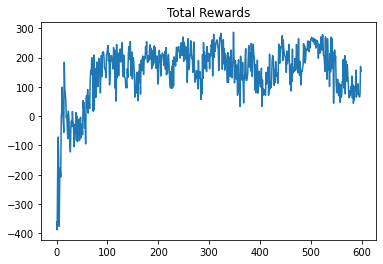

In [ ]:
# final score
plt.plot(avg_total_rewards)
plt.title("Total Rewards")
plt.show()

In addition, `avg_final_reward` represents average final rewards of episodes. To be specific, final rewards is the last reward received in one episode, indicating whether the craft lands successfully or not.


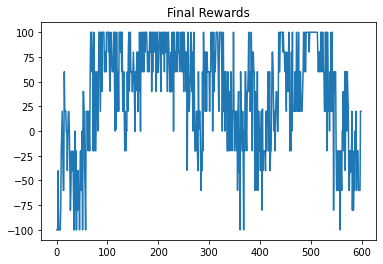

In [ ]:
# to see if craft lands on surface successfully
plt.plot(avg_final_rewards)
plt.title("Final Rewards")
plt.show()

In [ ]:
best_batch


0

In [ ]:
#from google.colab import files
#files.download(PATH)

# Server 
The code below simulate the environment on the judge server. Can be used for testing.

In [ ]:
PATH = "Action_List_test" + str(best_batch) + ".npy"
action_list = np.load(PATH,allow_pickle=True) 
seed = 543 
fix(env, seed)

#agent.network.eval()  

test_total_reward = []
for actions in action_list:
    state = env.reset()
    img = plt.imshow(env.render(mode='rgb_array'))

    total_reward = 0

    done = False
    # while not done:
    done_count = 0
    for action in actions:
        # action, _ = agent1.sample(state)
        state, reward, done, _ = env.step(action)
        done_count += 1
        total_reward += reward
        if done:
            break
    #   img.set_data(env.render(mode='rgb_array'))
    #   display.display(plt.gcf())
    #   display.clear_output(wait=True)
    print(f"Your reward is : %.2f"%total_reward)
    test_total_reward.append(total_reward)

FileNotFoundError: [Errno 2] No such file or directory: 'Action_List_test0.npy'

# Your score

In [ ]:
print(f"Your final mean reward is : %.2f"%np.mean(test_total_reward))

Your final mean reward is : 295.43


## Reference

Below are some useful tips for you to get high score.

- [DRL Lecture 1: Policy Gradient (Review)](https://youtu.be/z95ZYgPgXOY)
- [ML Lecture 23-3: Reinforcement Learning (including Q-learning) start at 30:00](https://youtu.be/2-JNBzCq77c?t=1800)
- [Lecture 7: Policy Gradient, David Silver](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/pg.pdf)
